In [17]:
import numpy as np
import pandas as pd
import re
from io import StringIO
from PIL import Image
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
\from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
\from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn import set_config
import warnings

from tqdm import tqdm
from wordcloud import WordCloud


In [19]:
csv_file_path = 'mbti_1.csv'

data = []

# Open the file with a specific encoding and remove null bytes
with open(csv_file_path, 'r', encoding='ISO-8859-1') as file:
    # Read the file content, removing null bytes
    file_content = file.read().replace('\0', '')

# Convert the cleaned content back into a file-like object for csv.reader
file_like_object = StringIO(file_content)

# Now, use csv.reader on the cleaned, file-like object
csv_reader = csv.reader(file_like_object, delimiter=',', quotechar='"')

# Skip the header row
next(csv_reader, None)

# Read each row from the csv_reader
for row in csv_reader:
    # Append the row to the data list
    if len(row) >= 2:  # Check to ensure there are at least two columns
        data.append({'type': row[0], 'posts': row[1]})

df = pd.DataFrame(data)

In [ ]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
fig = px.histogram(df, x='type', title='Histogram of Types')

fig.update_layout(
    xaxis_title='Type',
    yaxis_title='Count',
    bargap=0.2,
)
fig.show()


In [4]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [20]:
#Function to clean up text
def clear_text(data):
    data_length=[]
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        #Making the text lower case
        sentence=sentence.lower()

        #removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)

        #removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)

        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [21]:
df_clean_posts, df_clean_length = clear_text(df)
df['cleaned_posts'] = df_clean_posts
df['posts_length']  = df_clean_length

100%|█████████████████████████████████████| 8675/8675 [00:07<00:00, 1143.15it/s]


In [22]:
# Encoding labels
lb = LabelEncoder()
y = pd.Series(lb.fit_transform(df['type']))

X = df['cleaned_posts'].to_frame()

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Reset the index of train and test datasets
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("X_train:", X_train.head())
print("X_test:", X_test.head())
print("y_train:", y_train.head())
print("y_test:", y_test.head())

X_train:                                        cleaned_posts
0   this is actually exactly what i expected    l...
1   nope   not now  not ever   i m too busy with ...
2   yes peace is the absence of conflict   your i...
3   i apologize for the delayed response  but tha...
4   nightglow  i can t even imagine what you must...
X_test:                                        cleaned_posts
0   macona   it depends if the big family has ext...
1      sveltihel     brilliant  but this was the ...
2     heylena    lol  compliment accepted  thank ...
3   2pac right       rocket coffin  like packed w...
4   the title of this thread is misleading  there...
y_train: 0     9
1    15
2     0
3     9
4     9
dtype: int64
y_test: 0     9
1     0
2     8
3     8
4    10
dtype: int64


In [23]:
classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced')),
    ('Support Vector Machine', SVC(random_state=42, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('Multinomial Naive Bayes', MultinomialNB())
]

vectorizers = [
    ('TF-IDF Vectorizer', TfidfVectorizer(stop_words='english')),
    ('Count Vectorizer', CountVectorizer(stop_words='english'))
]

results = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each vectorizer and classifier combination
for vec_name, vectorizer in vectorizers:
    for cls_name, classifier in classifiers:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        fold_metrics = {'configuration': f'{vec_name} with {cls_name}', 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        fold_conf_matrices = []

        # Perform cross-validation
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            pipeline.fit(X_train['cleaned_posts'], y_train)
            y_pred = pipeline.predict(X_test['cleaned_posts'])

            fold_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            fold_metrics['precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            fold_metrics['recall'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
            fold_metrics['f1'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
            fold_conf_matrices.append(confusion_matrix(y_test, y_pred).tolist())

        # Store averaged metrics and confusion matrices per fold
        results.append({
            'configuration': fold_metrics['configuration'],
            'average_accuracy': np.mean(fold_metrics['accuracy']),
            'average_precision': np.mean(fold_metrics['precision']),
            'average_recall': np.mean(fold_metrics['recall']),
            'average_f1': np.mean(fold_metrics['f1']),
            'confusion_matrices': json.dumps(fold_conf_matrices)  # Converting list of matrices to JSON string
        })

pd.DataFrame(results).to_csv('final_classification_results.csv', index=False)

/Users/abhimanyu_sharma/Desktop/Ashoka_Spring_2024/NLP/assignment3/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/abhimanyu_sharma/Desktop/Ashoka_Spring_2024/NLP/assignment3/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

In [24]:
results

[{'configuration': 'TF-IDF Vectorizer with Logistic Regression',
  'average_accuracy': 0.6914121037463976,
  'average_precision': 0.6971690228389974,
  'average_recall': 0.6914121037463976,
  'average_f1': 0.6917327038600941,
  'confusion_matrices': '[[[22, 2, 0, 0, 0, 0, 0, 0, 6, 2, 2, 0, 0, 2, 0, 2], [3, 82, 5, 5, 0, 3, 0, 0, 6, 13, 9, 5, 1, 0, 1, 2], [1, 0, 31, 2, 0, 0, 0, 1, 2, 2, 4, 3, 0, 0, 0, 1], [1, 9, 1, 98, 0, 0, 0, 0, 3, 4, 6, 8, 2, 2, 2, 1], [0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 1, 2, 0, 3, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0], [0, 0, 1, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 1, 0, 1], [0, 0, 1, 2, 1, 0, 0, 8, 0, 0, 0, 2, 0, 1, 0, 3], [9, 6, 4, 8, 2, 2, 0, 1, 198, 28, 13, 11, 1, 6, 1, 4], [5, 10, 2, 4, 2, 2, 0, 1, 19, 270, 11, 20, 3, 11, 2, 4], [3, 6, 7, 2, 1, 1, 0, 1, 9, 3, 151, 21, 0, 4, 2, 7], [0, 2, 6, 12, 3, 0, 0, 1, 8, 12, 14, 189, 0, 6, 0, 8], [1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 25, 1, 0, 1], [0, 1, 0, 2, 0, 1, 0, 0, 2, 10, 1, 1, 1, 35, 0, 0], [0, 2, 0, 1, 0, 0, 

In [27]:
for result in results:
    print(result['configuration'])
    print(result['average_accuracy'])
    print(result['average_precision'])
    print(result['average_recall'])
    print(result['average_f1'])

TF-IDF Vectorizer with Logistic Regression
0.6914121037463976
0.6971690228389974
0.6914121037463976
0.6917327038600941
TF-IDF Vectorizer with Support Vector Machine
0.6280115273775215
0.6463181833007485
0.6280115273775215
0.6138485255336215
TF-IDF Vectorizer with Random Forest
0.5194236311239193
0.5870484770386195
0.5194236311239193
0.48167735473582746
TF-IDF Vectorizer with Multinomial Naive Bayes
0.21152737752161385
0.1220632780956989
0.21152737752161385
0.07461408520211055
Count Vectorizer with Logistic Regression
0.6235158501440923
0.6205410184201059
0.6235158501440923
0.6188513810488809
Count Vectorizer with Support Vector Machine
0.657521613832853
0.6608670500584127
0.657521613832853
0.652151263402881
Count Vectorizer with Random Forest
0.5167723342939481
0.5835337091748215
0.5167723342939481
0.47929560115116143
Count Vectorizer with Multinomial Naive Bayes
0.4050720461095101
0.3756055293959662
0.4050720461095101
0.320598379681892


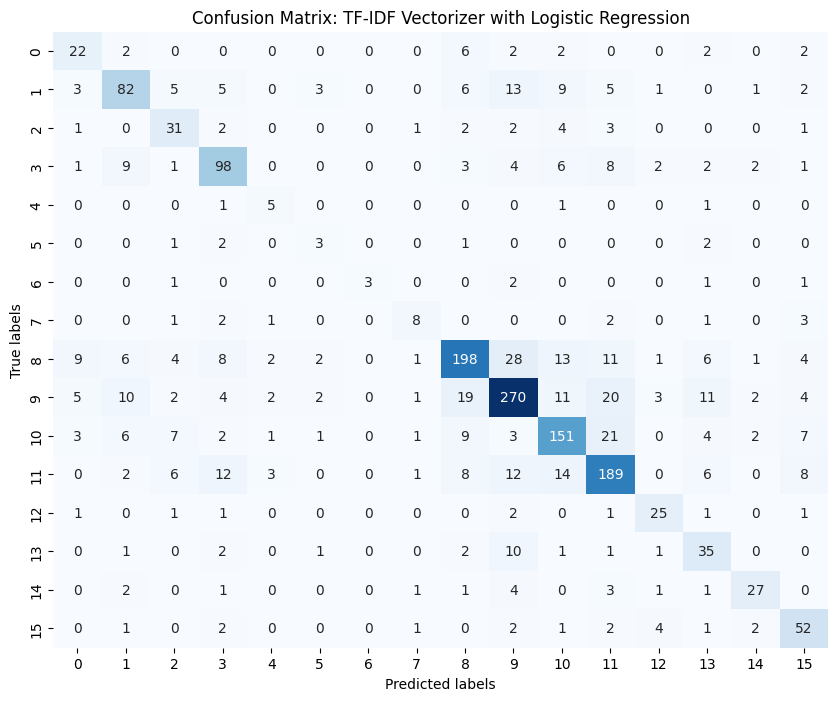

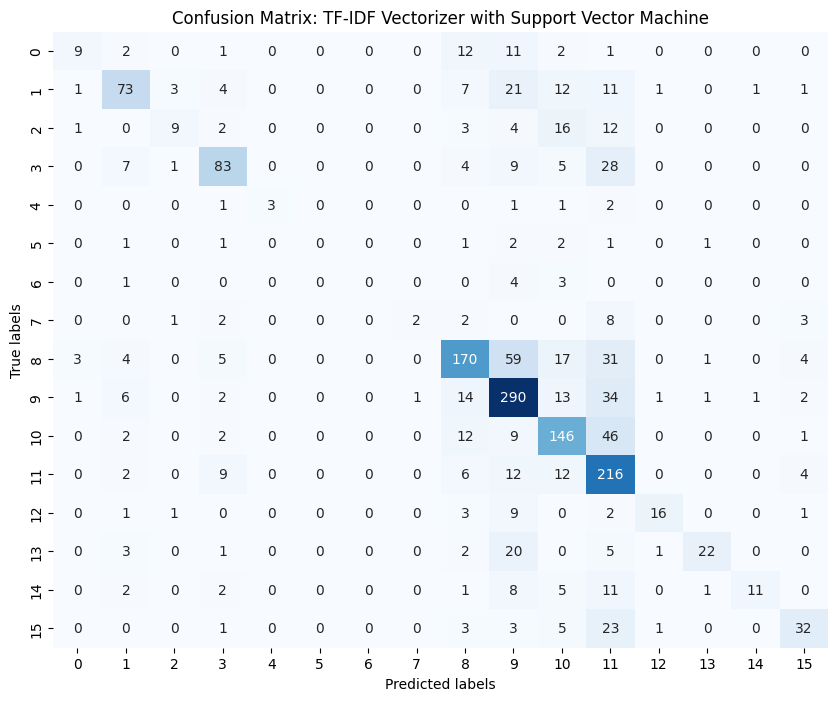

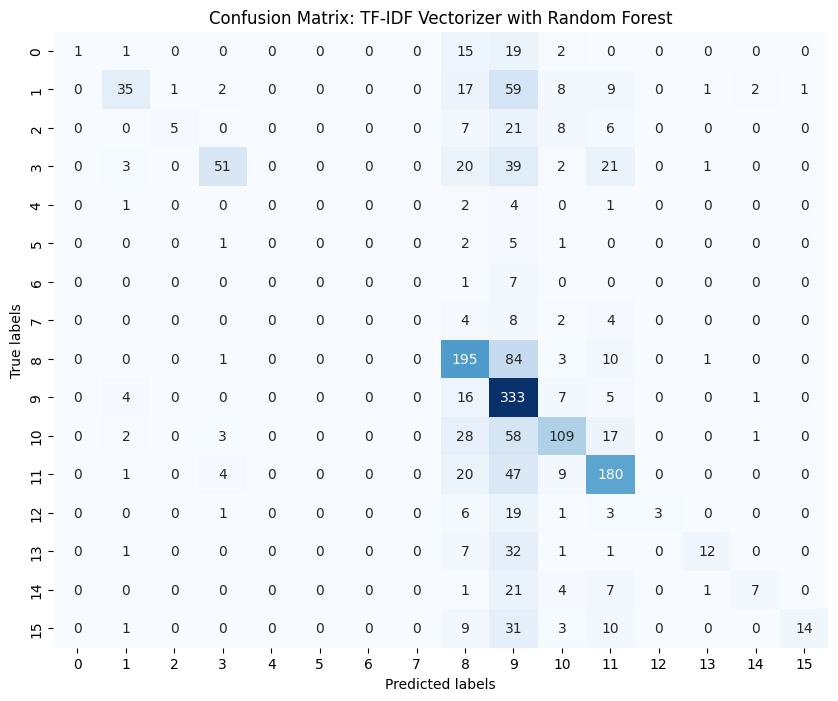

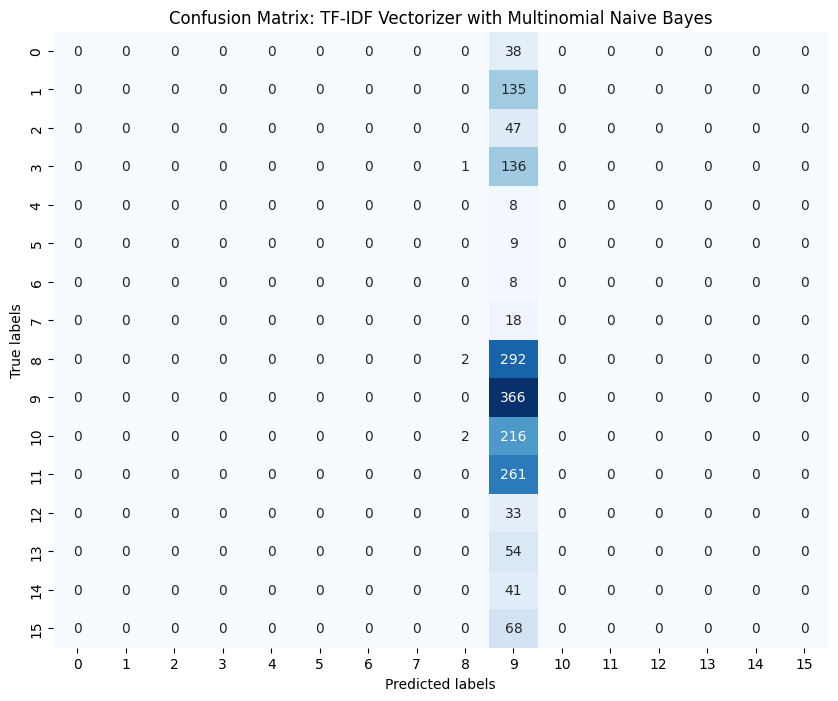

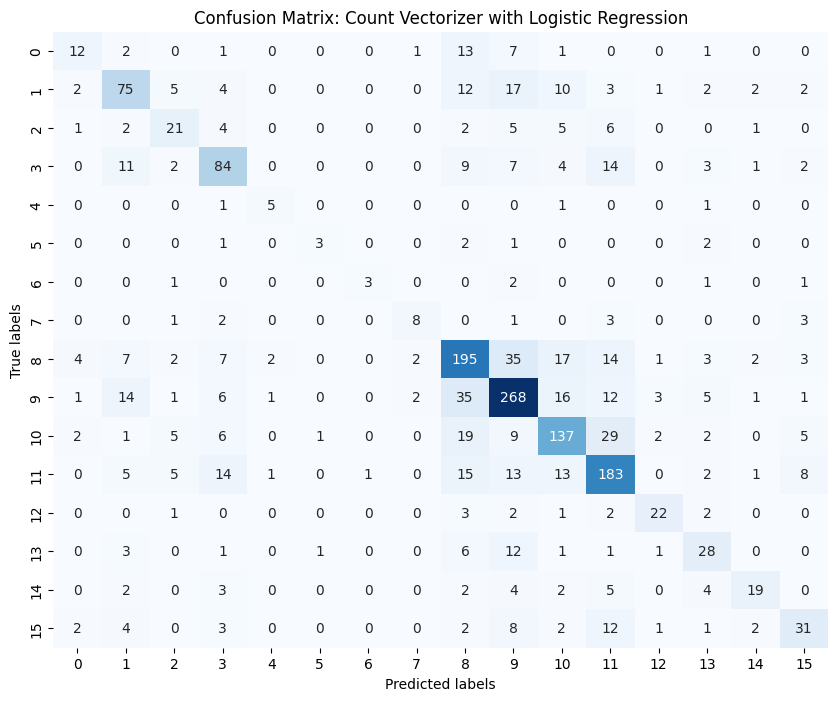

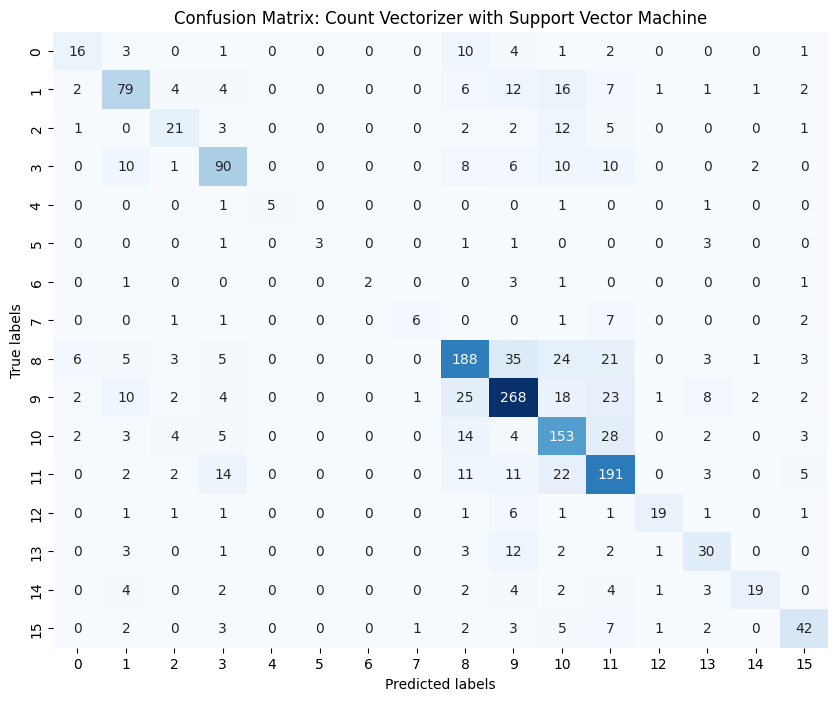

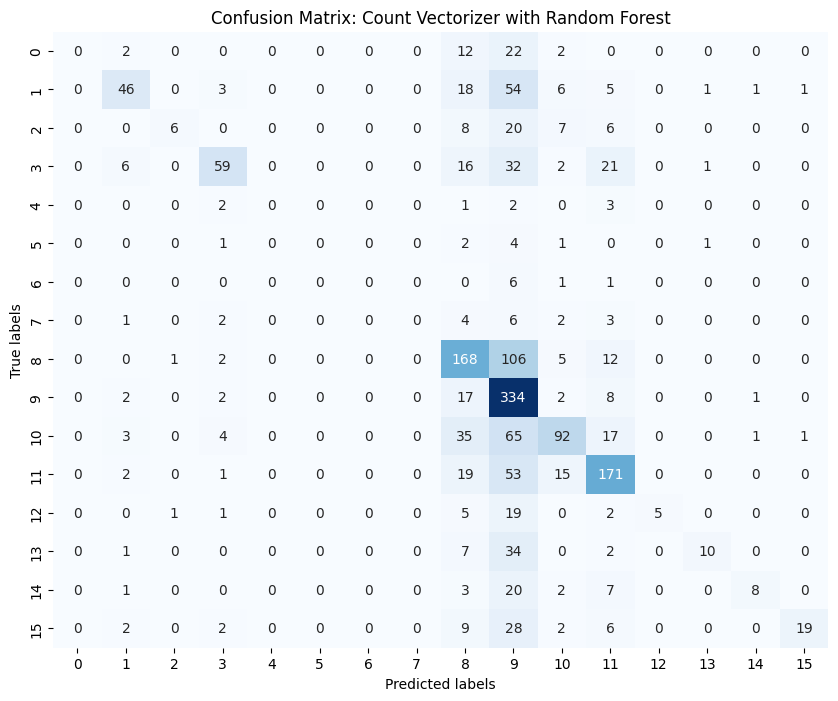

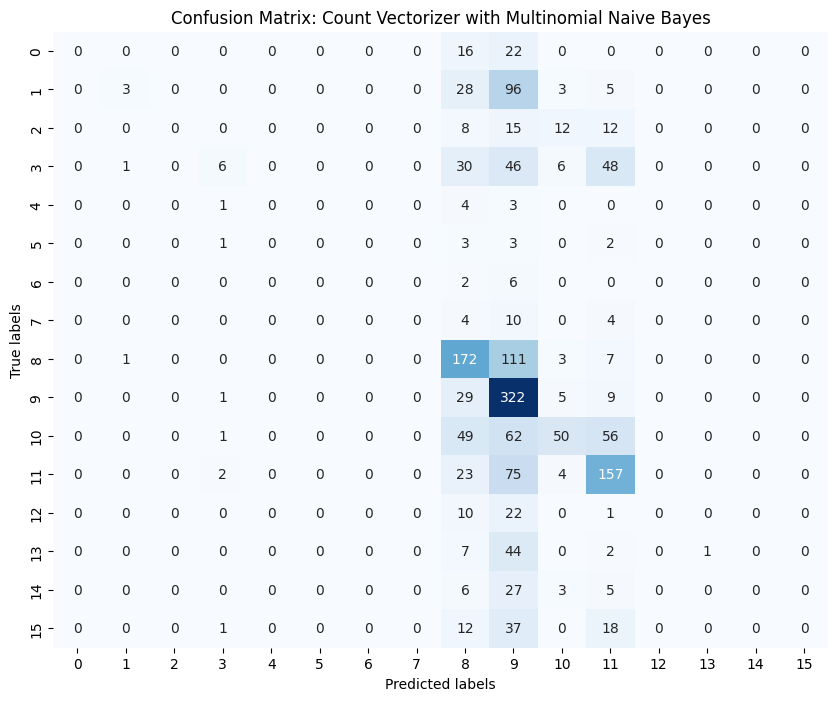

In [25]:
# Extracting the confusion matrices and plotting them
for result in results:
    configuration = result['configuration']
    confusion_matrices = eval(result['confusion_matrices'])  # Using eval to convert string representation back to list

    first_matrix = np.array(confusion_matrices[0])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(first_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {configuration}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


In [ ]:
# Define parameter grids for the top 3 performing classifier vectorizer pairs
param_grid_lr_tfidf = {
    'vectorizer__max_features': [500, 1000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__min_df': [1, 3, 5],
    'classifier__C': [1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

param_grid_svc = {
    'vectorizer__max_features': [500, 1000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__min_df': [1, 3, 5],
    'classifier__C': [1, 10, 100],
    'classifier__gamma': ['scale', 'auto']
}

# Set up pipelines for each combination
pipeline_lr_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

pipeline_svc_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC())
])

pipeline_svc_count = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC())
])

# Set up GridSearchCV objects
grid_search_lr_tfidf = GridSearchCV(pipeline_lr_tfidf, param_grid_lr_tfidf, cv=5, scoring='accuracy')
grid_search_svc_tfidf = GridSearchCV(pipeline_svc_tfidf, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc_count = GridSearchCV(pipeline_svc_count, param_grid_svc, cv=5, scoring='accuracy')

# Perform the grid search
# For Logistic Regression with TF-IDF Vectorizer
grid_search_lr_tfidf.fit(X_train['cleaned_posts'], y_train)
# For SVM with TF-IDF Vectorizer
grid_search_svc_tfidf.fit(X_train['cleaned_posts'], y_train)
# For SVM with Count Vectorizer
grid_search_svc_count.fit(X_train['cleaned_posts'], y_train)

# Best parameters and best score
print("Best parameters (TF-IDF + LR):", grid_search_lr_tfidf.best_params_)
print("Best cross-validation score (TF-IDF + LR):", grid_search_lr_tfidf.best_score_)

print("Best parameters (TF-IDF + SVM):", grid_search_svc_tfidf.best_params_)
print("Best cross-validation score (TF-IDF + SVM):", grid_search_svc_tfidf.best_score_)

print("Best parameters (Count + SVM):", grid_search_svc_count.best_params_)
print("Best cross-validation score (Count + SVM):", grid_search_svc_count.best_score_)

#Save results to a JSON file to access later easily
def save_results(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

# Extract the best parameters and scores
results_data = {
    'TF-IDF + Logistic Regression': {
        'best_parameters': grid_search_lr_tfidf.best_params_,
        'best_score': grid_search_lr_tfidf.best_score_
    },
    'TF-IDF + SVM': {
        'best_parameters': grid_search_svc_tfidf.best_params_,
        'best_score': grid_search_svc_tfidf.best_score_
    },
    'Count + SVM': {
        'best_parameters': grid_search_svc_count.best_params_,
        'best_score': grid_search_svc_count.best_score_
    }
}

save_results('grid_search_results.json', results_data)
print("Results saved successfully!")



/Users/abhimanyu_sharma/Desktop/Ashoka_Spring_2024/NLP/assignment3/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/abhimanyu_sharma/Desktop/Ashoka_Spring_2024/NLP/assignment3/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt